In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
import scipy

from sklearn.metrics import roc_curve, auc, precision_recall_curve

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import helper 

from Bio import AlignIO
import time as time
import pandas as pd

# Load Data, get base paired indices and remove gaps

In [2]:
starttime = time.time()

#Open data from h5py

data_path = '../../../data_RFAM/glna_100k_d8.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

X_train = X_data[shuffle[:split_1], :, 0, :]
X_valid = X_data[shuffle[split_1:split_2], :, 0, :]
X_test = X_data[shuffle[split_2:], :, 0, :]

Y_train = Y_data[shuffle[:split_1]]
Y_valid = Y_data[shuffle[split_1:split_2]]
Y_test = Y_data[shuffle[split_2:]]
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 10.68s


In [3]:
simalign_file = '../../../data_RFAM/glnAsim_100k.sto'

#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)

In [4]:
def unalign(X):
    nuc_index = np.where(np.sum(X, axis=1)!=0)
    return (X[nuc_index])

X_train_unalign = [unalign(X) for X in X_train]
X_valid_unalign = [unalign(X) for X in X_valid]
X_test_unalign = [unalign(X) for X in X_test]

# Build the 2 layer LSTM

In [5]:
tf.reset_default_graph()

num_hidden = 64
num_layers = 2
num_classes = Y_train.shape[1]

# tf Graph input
X = tf.placeholder(tf.float32, [None, None, X_train[0].shape[1]], name='inputs')
Y = tf.placeholder(tf.float32, [None, num_classes], name='ouputs')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

cells = []
for _ in range(num_layers):
    cell = tf.contrib.rnn.LSTMCell(num_hidden)#LayerNormBasicLSTMCell(num_hidden)  # Or LSTMCell(num_units)
    cell = tf.contrib.rnn.DropoutWrapper(cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)
    cells.append(cell)

multicell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

outputs, states = tf.nn.dynamic_rnn(cell=multicell, 
                                    inputs=X, 
                                    sequence_length=helper.length(X), dtype=tf.float32)

# Linear activation, using rnn inner loop last output
W_out = tf.Variable(tf.random_normal([num_hidden, num_classes]), name='W_out')
b_out = tf.Variable(tf.random_normal([num_classes]), name='b_out')

#last = tf.gather(outputs, int(outputs.get_shape()[1])-1)  
#last = int(outputs.get_shape()[1]) - 1
logits = tf.matmul(states[-1].h, W_out) + b_out
predictions = tf.nn.sigmoid(logits)

In [6]:
# The Optimizer

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# Define loss and optimizer
predictions = tf.clip_by_value(predictions, clip_value_max=1-1e-7, clip_value_min=1e-7)
#cost = tf.reduce_sum(Y*tf.log(predictions), axis=1)
cost = tf.reduce_sum(Y*tf.log(predictions)+(1-Y)*tf.log(1-predictions), axis=1)

total_loss = tf.reduce_mean(-cost)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads = optimizer.compute_gradients(total_loss)

# Apply gradients.
apply_gradient_op = optimizer.apply_gradients(grads)

# Track the moving averages of all trainable variables.
variable_averages = tf.train.ExponentialMovingAverage(0.9)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
    train_op = tf.no_op(name='train')

# Evaluate model (with test logits, for dropout to be disabled)
#correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
correct_pred = tf.equal(tf.round(predictions), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Train model

In [7]:
# start session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
batch_size = 128
train_batches = helper.bucket_generator(X_train_unalign, Y_train, batch_size)
valid_batches = helper.bucket_generator(X_valid_unalign, Y_valid, batch_size)
num_epochs = 50
bar_length = 25
patience = 10


# path to save results
save_path = '../../../results/glnA'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_filename = 'RNN_t2' + '_best'
params_path = os.path.join(save_path, params_filename)
    
wait=0
min_loss = 1e10
for epoch in range(num_epochs):
    print('epoch: '+ str(epoch+1))
    
    num_batches = len(train_batches)
    shuffled_batches = []
    for i in np.random.permutation(num_batches):
        shuffled_batches.append(train_batches[i])
        
    loss = 0
    acc = 0
    start_time = time.time()
    for i, batch in enumerate(shuffled_batches):
        batch_loss, batch_acc, _ = sess.run([total_loss, accuracy, train_op], feed_dict={X: batch[0], 
                                                                                      Y: batch[1], 
                                                                                      keep_prob: 0.5,
                                                                                      learning_rate: 0.0003})            
        loss += batch_loss
        acc += batch_acc

        remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
        percent = float(i)/num_batches
        progress = '='*int(round(percent*bar_length))
        spaces = ' '*int(bar_length-round(percent*bar_length))
        sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
        %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))
        
    sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
    %(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
    sys.stdout.write("\n")
    
    
    num_batches = len(valid_batches)
    loss = 0
    acc = 0
    valid_predictions = []
    valid_truth = []
    start_time = time.time()
    for i, batch in enumerate(valid_batches):
        batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                                Y: batch[1], 
                                                                                keep_prob: 1.0})            
        loss += batch_loss
        valid_predictions.append(batch_predict)
        valid_truth.append(batch[1])
    valid_loss = loss/num_batches
    valid_predictions = np.vstack(valid_predictions)
    valid_truth = np.vstack(valid_truth)
    
    correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
    auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
    auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
    print("  valid loss  = "+str(loss/num_batches))
    print("  valid acc   = "+str(np.nanmean(correct)))
    print("  valid AUROC = "+str(np.nanmean(auc_roc)))
    print("  valid AUPRC = "+str(np.nanmean(auc_pr)))
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            print("Patience ran out... early stopping!")
            break

epoch: 1
[=========================] 99.9% -- elapsed time=58.29s -- loss=0.49352 -- acc=0.7504551

  valid loss  = 0.3579328539455013
  valid acc   = 0.8474
  valid AUROC = 0.9178136813863101
  valid AUPRC = 0.9291690824564014
  Lower validation loss found. Saving parameters to: ../../../results/glnA/RNN_t2_best
epoch: 2
[=========================] 99.9% -- elapsed time=58.33s -- loss=0.35563 -- acc=0.8491997

  valid loss  = 0.318525690466735
  valid acc   = 0.87105
  valid AUROC = 0.9349311872170488
  valid AUPRC = 0.9439224393163947
  Lower validation loss found. Saving parameters to: ../../../results/glnA/RNN_t2_best
epoch: 3
[=========================] 99.9% -- elapsed time=58.45s -- loss=0.32199 -- acc=0.8677551

  valid loss  = 0.2963445384743487
  valid acc   = 0.87965
  valid AUROC = 0.9433855046988271
  valid AUPRC = 0.9513404354327404
  Lower validation loss found. Saving parameters to: ../../../results/glnA/RNN_t2_best
epoch: 4
[=========================] 99.9% -- elapsed 

In [10]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# Test Model

In [8]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../../../results/glnA'
params_filename = 'RNN_t2' + '_best'
params_path = os.path.join(save_path, params_filename)

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../../../results/glnA/RNN_t2_best


In [10]:
batch_size = 128
batches = helper.bucket_generator(X_test_unalign, Y_test, batch_size)
num_batches = len(batches)

loss = 0
acc = 0
valid_predictions = []
valid_truth = []
start_time = time.time()
num_batches = len(batches)
bar_length = 25

for i, batch in enumerate(batches):

    batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                            Y: batch[1], 
                                                                            keep_prob: 1.0})            
    loss += batch_loss
    valid_predictions.append(batch_predict)
    valid_truth.append(batch[1])
    
    remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
    percent = float(i)/num_batches
    progress = '='*int(round(percent*bar_length))
    spaces = ' '*int(bar_length-round(percent*bar_length))
    sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
    %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))

sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
%(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
sys.stdout.write("\n")

valid_predictions = np.vstack(valid_predictions)
valid_truth = np.vstack(valid_truth)

correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
mean = [np.nanmean(correct), np.nanmean(auc_roc), np.nanmean(auc_pr)]
std = [np.nanstd(correct), np.nanstd(auc_roc), np.nanstd(auc_pr)]

print("  test loss  = "+str(loss/num_batches))
print("  test acc   = "+str(np.nanmean(correct)))
print("  test AUROC = "+str(np.nanmean(auc_roc)))
print("  test AUPRC = "+str(np.nanmean(auc_pr)))

[=========================] 99.8% -- elapsed time=10.45s -- loss=0.11404 -- acc=0.000000

  test loss  = 0.11404005305614195
  test acc   = 0.9588166666666667
  test AUROC = 0.9904956735790262
  test AUPRC = 0.9919177261856822


In [11]:
starttime = time.time()
# add zero padding
lengths = []
for x in X_test_unalign:
    lengths.append(x.shape[0])
lengths = np.array(lengths)

# sort the lengths
sort_index = np.argsort(lengths)
MAX = len(X_test_unalign[sort_index[-1]])

test_predict = sess.run(logits, feed_dict={X: helper.pad_inputs(X_test_unalign, MAX)[0], keep_prob: 1.0})   
plot_index = np.argsort(test_predict[:,0])[::-1]

print (time.time() - starttime)

4.51156306267


# Second Order Mutagenesis

In [12]:
def second_order_mutagenesis(sess, predictions, X_val, ugidx):
    seqlen, dims = X_val.shape
    idxlen = len(ugidx)

    # get wild-type score
    wt_score = sess.run(logits, feed_dict={X: np.expand_dims(unalign(X_val), axis=0), keep_prob: 1.0})[0]     

    # generate mutagenesis sequences
    num_mut = idxlen**2*dims**2
    X_mut = np.einsum('nl,lka->nka', np.ones((num_mut, 1)), np.expand_dims(X_val, axis=0))

    k=0
    for position1 in ugidx:
        for position2 in ugidx:
            for nuc1 in range(dims):
                for nuc2 in range(dims):
                    X_mut[k, position1, :] = 0
                    X_mut[k, position1, nuc1] = 1        
                    X_mut[k, position2, :] = 0
                    X_mut[k, position2, nuc2] = 1        
                    k += 1

    # get second order mutagenesis score
    X_mut_unalign = [unalign(x) for x in X_mut]
    mut_scores = []
    batches = helper.batch_generator(X_mut_unalign, batch_size=512, MAX=None, shuffle_data=False)
    for i, batch in enumerate(batches):
        batch_predict = sess.run(logits, feed_dict={X: batch, keep_prob: 1.0})            
        mut_scores.append(batch_predict)
    mut_scores = np.vstack(mut_scores)
    
    # calculate log-odds score
    log_odds = np.log(mut_scores + 1e-7) - np.log(wt_score + 1e-7)


    # reshape second order scores
    second_mutagenesis = np.zeros((idxlen, idxlen, dims, dims))
    k = 0
    for i in range(idxlen):
        for j in range(idxlen):
            for m in range(dims):
                for n in range(dims):
                    second_mutagenesis[i,j,m,n] = log_odds[k,0]
                    k += 1
    return second_mutagenesis

In [13]:
starttime = time.time()
N = 20#len(pos_index)
mutagenesis = []# np.zeros((N, seq_length, seq_length, num_alphabet, num_alphabet))
for i, index in enumerate(plot_index[:N]):
    mutagenesis.append(second_order_mutagenesis(sess, predictions, X_test[index], ugidx))
    if np.mod(i+1, 5) == 0:
        print("%d out of %d"%(i+1,N))
        print(time.time() - starttime)

5 out of 20
28.6365139484
10 out of 20
55.5654499531
15 out of 20
84.4939031601
20 out of 20
110.333490133


In [30]:
np.shape(mutagenesis)

(20, 61, 61, 4, 4)

In [14]:
#average the values
mean_mut2 = np.mean(mutagenesis, axis=0)

<function matplotlib.pyplot.show>

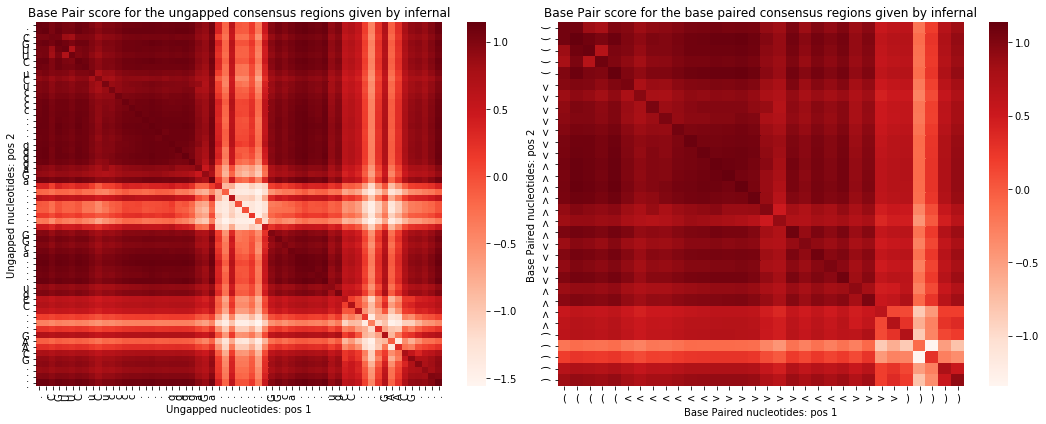

In [51]:
#Let's try something weird
bpfilter = np.ones((4,4))*1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = -1.
    
C = np.sum(np.clip(mean_mut2, a_max= 0., a_min=np.log(0.75)*bpfilter).reshape(numug,numug,dims*dims), axis=2)
#C = np.sum((mean_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
#C = C - np.mean(C)
#C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=None, cmap='Reds', linewidth=0.00)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=None, vmax=None, cmap='Reds', linewidth=0.0)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show